In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import os
import sys

parent = os.path.dirname(os.getcwd())  # workaround to import from utils/
sys.path.append(parent)

from utils.db_utils import df_from_snowflake

In [2]:
query = """
WITH cte_micro_conversion as(
    select
        PROVIDER_ID
    ,   SITE_ID
    ,   DEVICE_TYPE
    ,   OFFER_BIDDING_TAGS
    ,   avg(REVENUE_CPC) as avg_revenue_cpc
    ,   median(REVENUE_CPC) as median_revenue_cpc
    ,   stddev(REVENUE_CPC) as std_revenue_cpc
    from stage.derived.MICRO_CONVERSIONS_REVENUE
    where
        TRUE
        AND REVENUE_CPC > 0
        AND CLICK_ID_TIMESTAMP > current_date - 90
    group by
        1,2,3,4
),
    cte_cpc_mismatch as (
    select                      --cpc revenue
        CLICK_ID_TIMESTAMP
    ,   concat(m.PROVIDER_ID, m.SITE_ID, m.DEVICE_TYPE, m.OFFER_BIDDING_TAGS)                                            AS object
    ,   REVENUE_CPC
    ,   avg(REVENUE_CPC) OVER (PARTITION BY object ORDER BY CLICK_ID_TIMESTAMP ASC ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING ) AS avg_7d
    ,   avg_7d - REVENUE_CPC as cpc_mismatch
    ,   avg_revenue_cpc
    ,   median_revenue_cpc
    ,   std_revenue_cpc
    from stage.derived.MICRO_CONVERSIONS_REVENUE m
    inner join cte_micro_conversion c ON concat(m.PROVIDER_ID, m.SITE_ID, m.DEVICE_TYPE, m.OFFER_BIDDING_TAGS) = concat(c.PROVIDER_ID, c.SITE_ID, c.DEVICE_TYPE, c.OFFER_BIDDING_TAGS)
    where m.CLICK_ID_TIMESTAMP > current_date - 91
    order by 2, 1
)
select *
from cte_cpc
;
"""

In [3]:
query_2 = """
select --cpc revenue
        CLICK_ID_TIMESTAMP
    ,   concat(m.PROVIDER_ID, m.SITE_ID, m.DEVICE_TYPE, m.OFFER_BIDDING_TAGS)                                            AS object
    ,   REVENUE_CPC
    ,   coalesce( avg(REVENUE_CPC) OVER (PARTITION BY object ORDER BY CLICK_ID_TIMESTAMP ASC ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING ), 0) AS avg_7clicks
    ,   coalesce( stddev(REVENUE_CPC) OVER (PARTITION BY object ORDER BY CLICK_ID_TIMESTAMP ASC ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING ),0) as std_7clicks
    ,   avg_7clicks - 1.96 * std_7clicks                    AS lower_bound_revenue_cpc
    ,   avg_7clicks + 1.96 * std_7clicks                    AS upper_bound_revenue_cpc
    ,   avg_7clicks - REVENUE_CPC                           AS cpc_mismatch
    ,   cpc_mismatch / REVENUE_CPC                          as pct_mismatch
    ,   IFF((REVENUE_CPC>=lower_bound_revenue_cpc) AND (REVENUE_CPC<=upper_bound_revenue_cpc), 'good', 'bad') as predict_performance

    from STAGE.derived.MICRO_CONVERSIONS_REVENUE m
--     inner join cte_micro_conversion c ON concat(m.PROVIDER_ID, m.SITE_ID, m.DEVICE_TYPE, m.OFFER_BIDDING_TAGS) = concat(c.PROVIDER_ID, c.SITE_ID, c.DEVICE_TYPE, c.OFFER_BIDDING_TAGS)
    where
        TRUE
        AND REVENUE_CPC > 0
        AND m.CLICK_ID_TIMESTAMP > current_date - 91
    order by 2, 1, 3
"""

In [4]:
query_3 = """
WITH cte_object as(
    select
       concat(PROVIDER_ID, SITE_ID, DEVICE_TYPE, OFFER_BIDDING_TAGS)                                            AS object
    ,  row_number() OVER(partition by object order by CLICK_ID_TIMESTAMP ASC)                                   as rn
    from STAGE.derived.MICRO_CONVERSIONS_REVENUE
    where
        TRUE
        AND REVENUE_CPC > 0
        AND CLICK_ID_TIMESTAMP > current_date - 90
    qualify rn > 1
),
    cte_cpc as (
    select --cpc revenue
        CLICK_ID_TIMESTAMP
    ,   concat(m.PROVIDER_ID, m.SITE_ID, m.DEVICE_TYPE, m.OFFER_BIDDING_TAGS)                                    AS object
    ,   REVENUE_CPC
    ,   coalesce( avg(REVENUE_CPC) OVER (PARTITION BY object ORDER BY CLICK_ID_TIMESTAMP ASC ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING ), 0) AS avg_7clicks
    ,   coalesce( stddev(REVENUE_CPC) OVER (PARTITION BY object ORDER BY CLICK_ID_TIMESTAMP ASC ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING ),0) as std_7clicks
    ,   avg_7clicks - 1.96 * std_7clicks                                                                        AS lower_bound_revenue_cpc
    ,   avg_7clicks + 1.96 * std_7clicks                                                                        AS upper_bound_revenue_cpc
    ,   avg_7clicks - REVENUE_CPC                                                                               AS cpc_mismatch
    ,   cpc_mismatch / REVENUE_CPC                                                                              as pct_mismatch
    ,   IFF((REVENUE_CPC>=lower_bound_revenue_cpc) AND (REVENUE_CPC<=upper_bound_revenue_cpc), 'good', 'bad')   as predict_performance
    from STAGE.derived.MICRO_CONVERSIONS_REVENUE m
--     inner join cte_micro_conversion c ON concat(m.PROVIDER_ID, m.SITE_ID, m.DEVICE_TYPE, m.OFFER_BIDDING_TAGS) = c.object
    where
        TRUE
        AND REVENUE_CPC > 0
        AND m.CLICK_ID_TIMESTAMP > current_date - 90
        AND object in (SELECT distinct object from cte_object)
    order by 2, 1, 3
)
select *
from cte_cpc;
"""

In [5]:
df = df_from_snowflake(query_3)

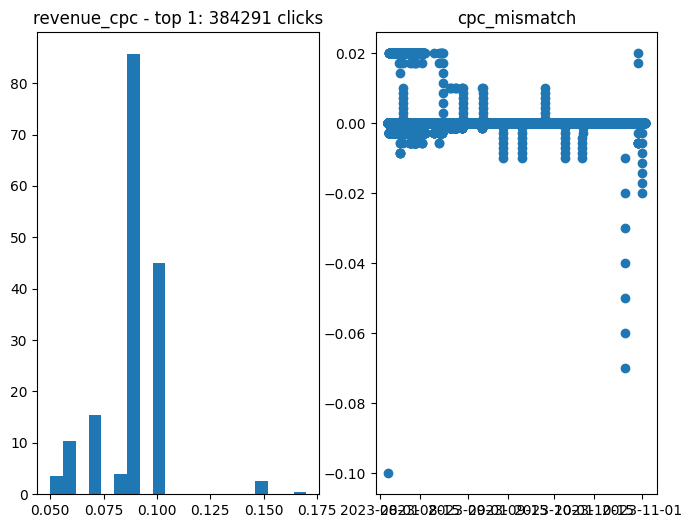

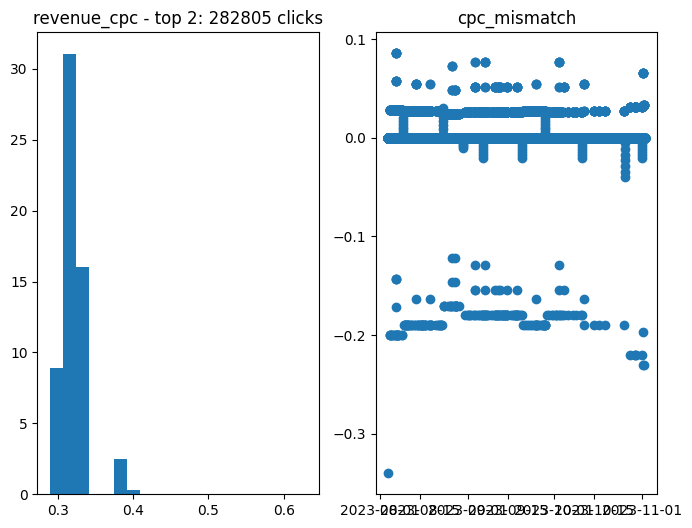

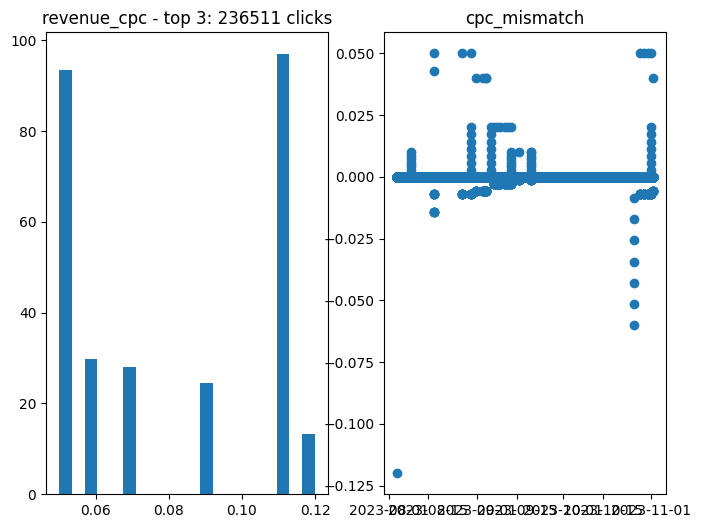

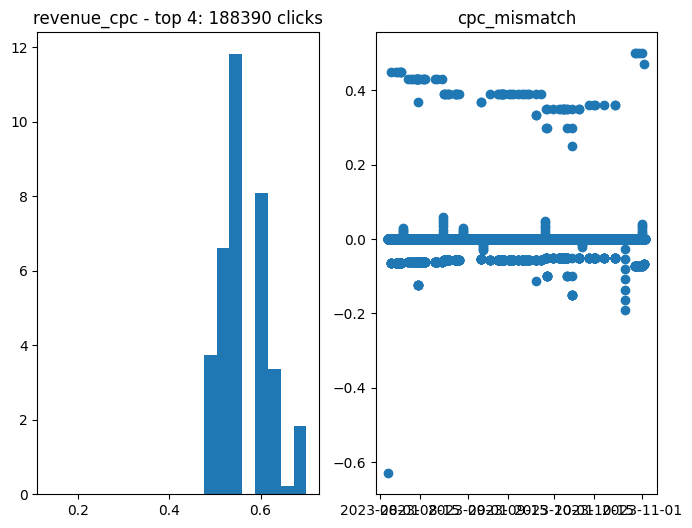

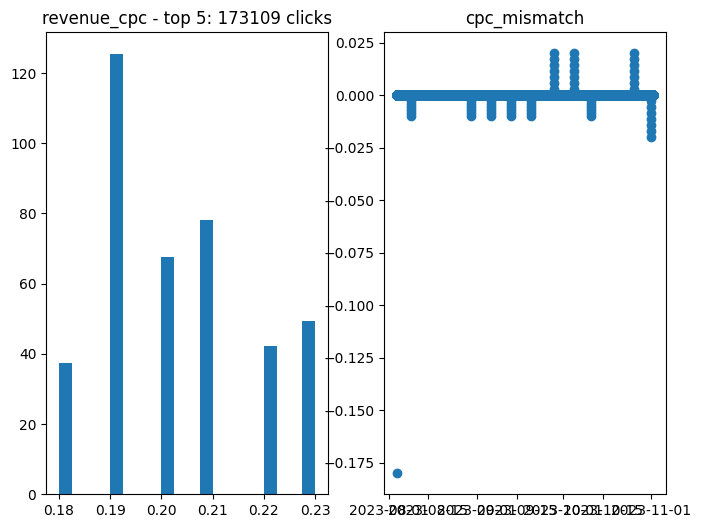

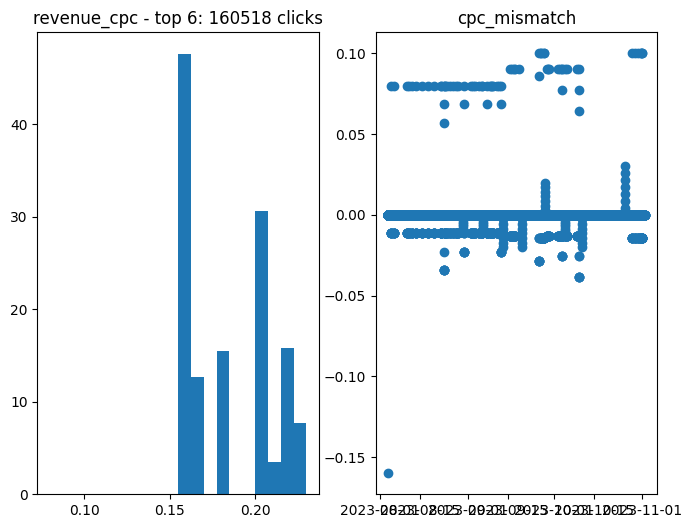

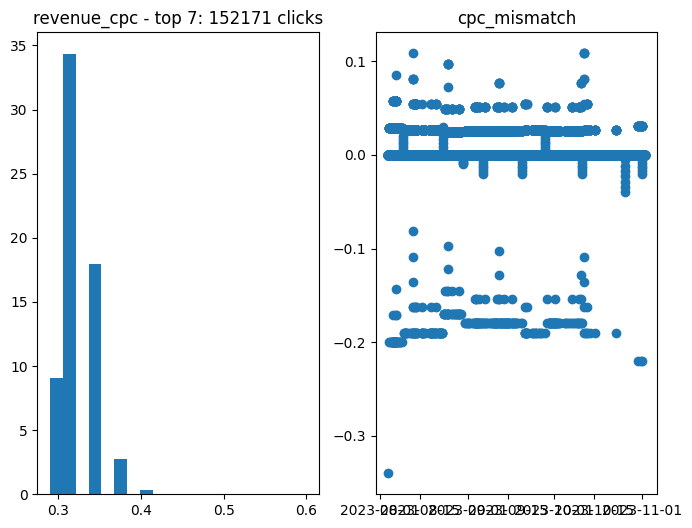

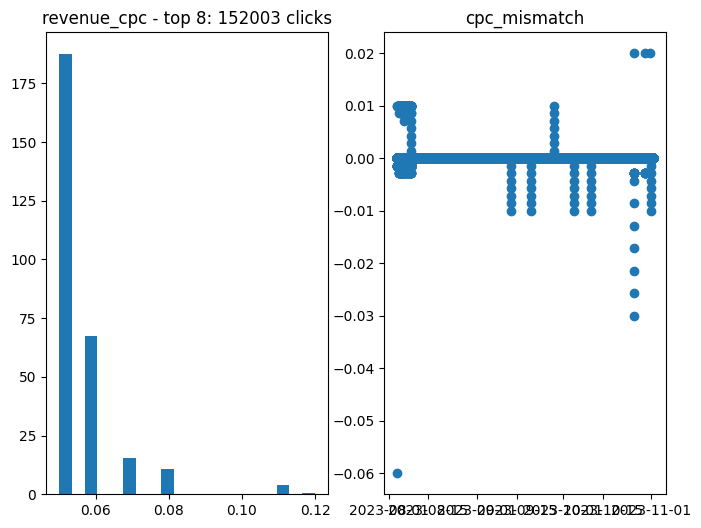

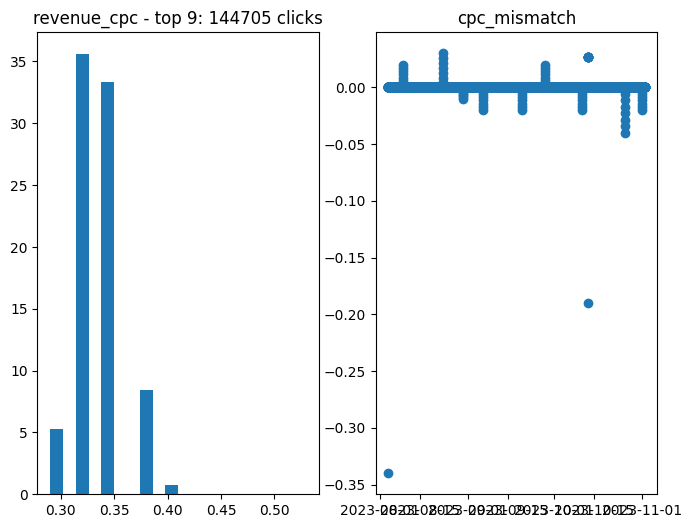

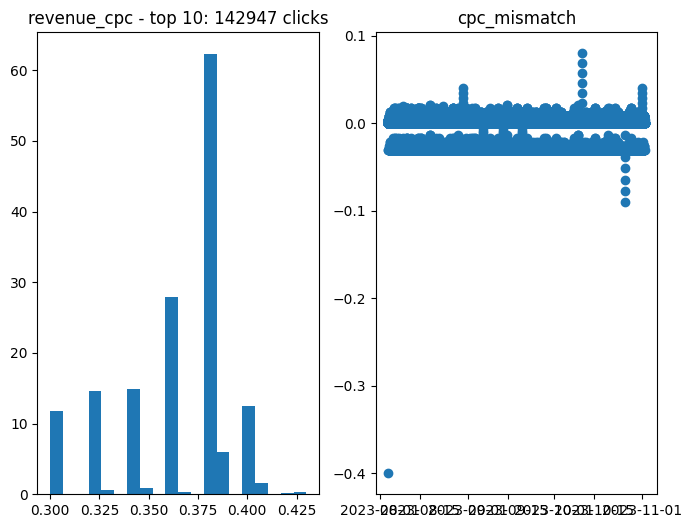

In [6]:
#PLOT
top_10 = df['OBJECT'].value_counts().head(10).reset_index()

for n, object in enumerate(top_10['OBJECT']):
    sample = df[df['OBJECT']==object]
    #print(str(len(sample)) + ' top ' + str(n))
    _, ax = pp.subplots(nrows=1, ncols=2, figsize=(8, 6))
    ax[0].hist(np.array(sample['REVENUE_CPC']), bins=20, density=True, histtype='stepfilled', alpha=1)
    ax[1].scatter(x=sample['CLICK_ID_TIMESTAMP'], y=np.array(sample['CPC_MISMATCH']), label='cpc_mismatch')
    ax[0].set_title('revenue_cpc' + ' - top ' + str(n+1) + ': ' + str(len(sample))+ ' clicks')
    ax[1].set_title('cpc_mismatch')
   

In [7]:
df

,CLICK_ID_TIMESTAMP,OBJECT,REVENUE_CPC,AVG_7CLICKS,STD_7CLICKS,LOWER_BOUND_REVENUE_CPC,UPPER_BOUND_REVENUE_CPC,CPC_MISMATCH,PCT_MISMATCH,PREDICT_PERFORMANCE
0,2023-08-18 16:10:19.883,bookingComcn.hometogo.comDesktop|bookingCom_CN10|,0.14,0E-8,0.000000,0.000000,0.000000,-0.14000000,-1.000000000000,bad
1,2023-08-18 16:10:26.977,bookingComcn.hometogo.comDesktop|bookingCom_CN10|,0.14,0.14000000,0.000000,0.140000,0.140000,0E-8,0E-12,good
2,2023-09-09 05:50:28.727,bookingComcn.hometogo.comDesktop|bookingCom_CN10|,0.10,0.14000000,0.000000,0.140000,0.140000,0.04000000,0.400000000000,bad
3,2023-10-18 07:06:08.331,bookingComcn.hometogo.comDesktop|bookingCom_CN10|,0.12,0.12666666,0.023094,0.081402,0.171931,0.00666666,0.055555500000,good
4,2023-10-18 07:06:42.010,bookingComcn.hometogo.comDesktop|bookingCom_CN10|,0.12,0.12500000,0.019149,0.087469,0.162531,0.00500000,0.041666666667,good
...,...,...,...,...,...,...,...,...,...,...
11097062,2023-10-18 15:34:34.716,wunderflatswimdu.deTablet|wunderflats_basic|,0.30,0.30000000,0.000000,0.300000,0.300000,0E-8,0E-12,good
11097063,2023-10-18 15:35:43.344,wunderflatswimdu.deTablet|wunderflats_basic|,0.30,0.30000000,0.000000,0.300000,0.300000,0E-8,0E-12,good
11097064,2023-10-22 20:49:07.778,wunderflatswimdu.deTablet|wunderflats_basic|,0.30,0.30000000,0.000000,0.300000,0.300000,0E-8,0E-12,good
11097065,2023-10-23 14:48:08.706,wunderflatswimdu.deTablet|wunderflats_basic|,0.30,0.30000000,0.000000,0.300000,0.300000,0E-8,0E-12,good


PCT_MISMATCH
 0.000000    10616940
-0.028571       11061
 0.011278        9275
-1.000000        7578
-0.029304        5691
               ...   
 0.401361           1
-0.029900           1
 3.793651           1
-0.146179           1
-0.220339           1
Name: count, Length: 6624, dtype: int64

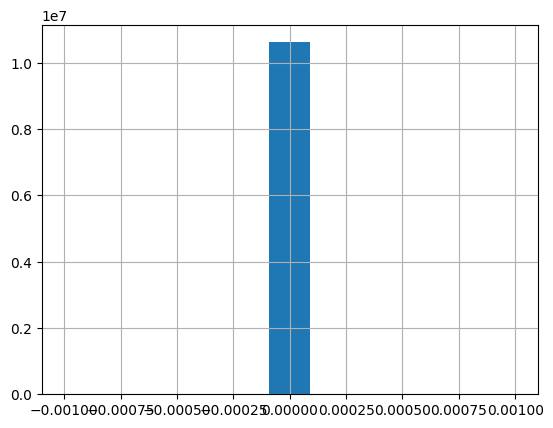

In [8]:

df['PCT_MISMATCH'].astype(float).hist(bins=11, density=False, histtype='bar', range=(-0.001,0.001))
df['PCT_MISMATCH'].astype(float).value_counts()

In [9]:
df['PCT_MISMATCH'].astype(float).sort_values(ascending=False)

7902976     5.571429
7901679     5.571429
7924624     5.571429
7924640     5.571429
7902759     5.571429
              ...   
11049260   -1.000000
11049263   -1.000000
973471     -1.000000
11049318   -1.000000
0          -1.000000
Name: PCT_MISMATCH, Length: 11097067, dtype: float64

<Axes: title={'center': 'predict_performance'}, ylabel='REVENUE_CPC'>

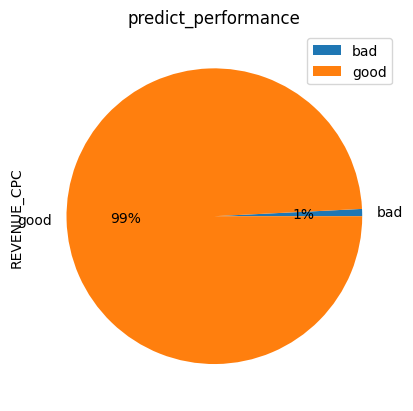

In [10]:
df.groupby(['PREDICT_PERFORMANCE']).count().plot(kind='pie', y='REVENUE_CPC', autopct='%1.0f%%', title='predict_performance')

In [12]:
from sklearn.metrics import mean_squared_error

pred = np.array(df['PCT_MISMATCH'])
actual = [0]*len(df)
rmse = mean_squared_error(actual,
                          pred,
                          squared=False 
                        ) 
rmse

0.1095014142600093